### 1. Import Packages

In [129]:
# Librerie di base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Librerie per la Data Imputation
from sklearn.impute import KNNImputer

# Librerie per la Hyperparameters Optimization
from sklearn.model_selection import GridSearchCV

# Librerie per il Machine Learning
from sklearn.cross_decomposition import PLSRegression
import sklearn.metrics as metrics
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict

# Librerie per la Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Librerie per la curva ROC
from sklearn.metrics import roc_curve, auc

print('All packages successfully loaded')

All packages successfully loaded


### 2. Load Data & Peak Sheet

In [130]:
df = pd.read_excel('../../../data/ST000369.xlsx')

# Rimuoviamo le colonne che non ci servono
df.drop(columns=["Idx", "SampleID", "Class"], inplace=True)

# Visualizziamo le prime 5 righe del dataset
df.head()

,SampleType,HealthState,SmokingStatus,Sex,M1,M2,M3,M4,M5,M6,...,M172,M173,M174,M175,M176,M177,M178,M179,M180,M181
0,Plasma,Adenocarcinoma,Former,F,194,168,77,105985,118,15489,...,195,1606,300,108,7203,43,59,1009,383,68
1,Plasma,Adenocarcinoma,Former,F,215,143,154,100462,133,13534,...,184,364,1364,160,11910,82,99,136,1021,165
2,Plasma,Adenocarcinoma,Current,F,104,67,45,75301,94,7390,...,189,157,884,73,6372,59,35,115,530,72
3,Plasma,Adenocarcinoma,Current,M,360,642,82,42097,84,50943,...,320,1621,461,104,14011,69,86,845,1309,127
4,Plasma,Adenocarcinoma,Current,M,96,137,95,112346,168,41987,...,84,769,266,158,18140,40,87,1213,1037,149


### 2.1 Data Cleaning

Per quanto riguarda il data cleaning del dataset, sono necessarie due tipologie di operazioni sui dati: 
1. Alcuni valori della feature "*HealthState*" sono scritti incorrettamente, perciò dobbiamo effettuarne la correzione.
2. Tre features binarie sono espresse attraverso stringhe e non valori binari (0 e 1), perciò dobbiamo fare la sostituzione.

In [131]:
# Effettuiamo la correzione dei valori errati
df["HealthState"] = df["HealthState"].str.replace('Adenocarcnoma', 'Adenocarcinoma')

# Eliminiamo le righe con valori nulli all'interno delle colonne "HealthState" e "Sex"
df = df.dropna(subset=["HealthState", "Sex"])

# Convertiamo i valori di natura categorica in valori numerici
df['Output'] = df['HealthState'].apply(lambda x: 1 if x in ['Adenosquamous', 'Adenocarcinoma'] else 0)
df['SmokingStatus'] = df['SmokingStatus'].apply(lambda x: 1 if x in ['Current'] else 0)
df['Sex'] = df['Sex'].apply(lambda x: 1 if x in ['F'] else 0)

# Visualizziamo le prime 5 righe del dataset
df.head()

,SampleType,HealthState,SmokingStatus,Sex,M1,M2,M3,M4,M5,M6,...,M173,M174,M175,M176,M177,M178,M179,M180,M181,Output
0,Plasma,Adenocarcinoma,0,1,194,168,77,105985,118,15489,...,1606,300,108,7203,43,59,1009,383,68,1
1,Plasma,Adenocarcinoma,0,1,215,143,154,100462,133,13534,...,364,1364,160,11910,82,99,136,1021,165,1
2,Plasma,Adenocarcinoma,1,1,104,67,45,75301,94,7390,...,157,884,73,6372,59,35,115,530,72,1
3,Plasma,Adenocarcinoma,1,0,360,642,82,42097,84,50943,...,1621,461,104,14011,69,86,845,1309,127,1
4,Plasma,Adenocarcinoma,1,0,96,137,95,112346,168,41987,...,769,266,158,18140,40,87,1213,1037,149,1


### 3. Extract X & Y

In [132]:
X = df.drop(columns=['SampleType', 'HealthState', 'Output'])
X_features_names = X.columns
y = df.Output

### 3.1 Data Imputation

In [133]:
# KNNImputer
imputer_knn = KNNImputer(n_neighbors=2)
imputer_knn.fit(X)
X[:] = imputer_knn.fit_transform(X)
X_knn = X.copy()

/var/folders/dv/cqkd8q211lb6w_8jd__s86d40000gn/T/ipykernel_2986/3462717103.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X[:] = imputer_knn.fit_transform(X)


### 3.2 Train-test Split

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X_knn, y, test_size=0.2, random_state=42)

### 4. Initial Model Build

In [135]:
# Definiamo il modello SVC con gli iperparametri di default
model = PLSRegression()

# Addestriamo il modello
model.fit(X_train, y_train)

# Eseguiamo le previsioni sui dati di test
y_pred = model.predict(X_test)

# Convertiamo le previsioni in etichette di classe utilizzando una soglia di 0.5
threshold = 0.5
y_pred_class = (y_pred[:, 0] > threshold).astype(int)

### 5. Initial Model Evalutation

In [136]:
# Valutiamo le prestazioni del modello con gli iperparametri di default
accuracy_knn = metrics.accuracy_score(y_test, y_pred_class)
precision_knn = metrics.precision_score(y_test, y_pred_class)
recall_knn = metrics.recall_score(y_test, y_pred_class)
f1_knn = metrics.f1_score(y_test, y_pred_class)
roc_auc_knn = metrics.roc_auc_score(y_test, y_pred_class)

print(f'Accuratezza: {accuracy_knn}')
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1-score: {f1_knn}')
print(f'ROC AUC: {roc_auc_knn}')

Accuratezza: 0.6060606060606061
Precision: 0.625
Recall: 0.5882352941176471
F1-score: 0.6060606060606061
ROC AUC: 0.6066176470588236


Le prestazioni iniziali sono estremamente deludenti: abbiamo un'accuratezza di 60%, una Precision di 62% e una Recall di 58%. Proviamo con la K-Fold Cross Validation.

In [137]:
max_accuracy = 0
k_best = 0

for k in range(5, 11):
    kfolds = KFold(n_splits=k, shuffle=True, random_state=42)
    model = PLSRegression()
    
    y_pred = cross_val_predict(model, X_knn, y, cv=kfolds)
    
    # Convertiamo le previsioni in etichette di classe utilizzando una soglia di 0.5
    threshold = 0.5
    y_pred_class = (y_pred[:, 0] > threshold).astype(int)
    
    accuracy = metrics.accuracy_score(y, y_pred_class)
    
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        k_best = k
    
    print(f"K={k}, Accuratezza Media: {accuracy}")

print("-------------------------------------------")
print(f"K ottimale: {k_best}")
print(f"Accuratezza massima: {max_accuracy}")

K=5, Accuratezza Media: 0.7177914110429447
K=6, Accuratezza Media: 0.7116564417177914
K=7, Accuratezza Media: 0.7116564417177914
K=8, Accuratezza Media: 0.7116564417177914
K=9, Accuratezza Media: 0.7361963190184049
K=10, Accuratezza Media: 0.7239263803680982
-------------------------------------------
K ottimale: 9
Accuratezza massima: 0.7361963190184049


In [138]:
# Creiamo l'oggetto K-Fold per la Cross-Validation con il numero di fold ottimale
kfolds = KFold(n_splits=k_best, shuffle=True, random_state=42)

### 6. Hyperparameters Optimization

L'**ottimizzazione degli iperparametri** è un passo fondamentale nello sviluppo di modelli predittivi robusti. Infatti, aderire ai parametri predefiniti impedisce ai modelli di raggiungere il massimo delle prestazioni. A tale scopo, utilizziamo la tecnica **Grid Search**.

In [139]:
# Creiamo un nuovo modello PLSRegression
model_2 = PLSRegression()

# Definiamo la griglia con i parametri da testare
param_grid = {
    'n_components': [2, 5, 10, 20],  
    'max_iter': [500, 1000, 1500],
    'tol': [1e-06, 1e-05, 1e-04]
}

# Creiamo l'oggetto GridSearchCV
grid_search = GridSearchCV(model_2, param_grid, cv=kfolds, n_jobs=-1)

# Eseguiamo la ricerca e cross-validation sui dati di addestramento
grid_search.fit(X_knn, y)

# Ottieniamo i migliori parametri
best_params = grid_search.best_params_

print(f"Best params: {best_params}")

Best params: {'max_iter': 500, 'n_components': 2, 'tol': 1e-06}


In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_knn, y, test_size=0.2, random_state=42)

In [141]:
# Creiamo un nuovo modello con i migliori parametri
best_model = PLSRegression(**best_params)

# Addestriamo il nuovo modello sui dati di addestramento
best_model.fit(X_train, y_train)

# Eseguiamo le previsioni sui dati di test
y_pred = best_model.predict(X_test)

# Convertiamo le previsioni in etichette di classe utilizzando una soglia di 0.5
threshold = 0.5
y_pred_class = (y_pred[:, 0] > threshold).astype(int)

In [142]:
# Valutiamo le prestazioni del modello con gli iperparametri ottimizzati
accuracy_knn = metrics.accuracy_score(y_test, y_pred_class)
precision_knn = metrics.precision_score(y_test, y_pred_class)
recall_knn = metrics.recall_score(y_test, y_pred_class)
f1_knn = metrics.f1_score(y_test, y_pred_class)
roc_auc_knn = metrics.roc_auc_score(y_test, y_pred_class)

print(f'Accuratezza: {accuracy_knn}')
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1-score: {f1_knn}')
print(f'ROC AUC: {roc_auc_knn}')

Accuratezza: 0.6060606060606061
Precision: 0.625
Recall: 0.5882352941176471
F1-score: 0.6060606060606061
ROC AUC: 0.6066176470588236


Riproviamo con la K-Fold Cross Validation.

In [143]:
y_pred = cross_val_predict(best_model, X_knn, y, cv=kfolds)

# Convertiamo le previsioni in etichette di classe utilizzando una soglia di 0.5
threshold = 0.5
y_pred_class = (y_pred[:, 0] > threshold).astype(int)

# Calcoliamo l'accuratezza media
scores = metrics.accuracy_score(y, y_pred_class)
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.7361963190184049


### 7. Feature Selection

In [144]:
max_fs = 0 
k_fs = 0
best_features = []

for k in range(2, len(X_knn.columns)):
    top_features = SelectKBest(score_func=chi2, k=k).fit(X_knn, y).get_support(indices=True)
    X_top = X_knn.iloc[:, top_features]

    y_pred = cross_val_predict(best_model, X_top, y, cv=kfolds)
    
    # Convertiamo le previsioni in etichette di classe utilizzando una soglia di 0.5
    threshold = 0.5
    y_pred_class = (y_pred[:, 0] > threshold).astype(int)
    
    scores = metrics.accuracy_score(y, y_pred_class)
    mean = np.mean(scores)
    
    if mean > max_fs: 
        max_fs = mean
        k_fs = k
        best_features = X_knn.columns[top_features].tolist()

    print(f"K={k}, Accuratezza Media: {mean}")

print(f"K ottimale: {k_fs}")
print(f"Accuratezza media ottimale: {max_fs}")
print(f"Features ottimali: {best_features}")

K=2, Accuratezza Media: 0.588957055214724
K=3, Accuratezza Media: 0.5950920245398773
K=4, Accuratezza Media: 0.6196319018404908
K=5, Accuratezza Media: 0.5950920245398773
K=6, Accuratezza Media: 0.6196319018404908
K=7, Accuratezza Media: 0.6625766871165644
K=8, Accuratezza Media: 0.6932515337423313
K=9, Accuratezza Media: 0.6993865030674846
K=10, Accuratezza Media: 0.6871165644171779
K=11, Accuratezza Media: 0.7055214723926381
K=12, Accuratezza Media: 0.6809815950920245
K=13, Accuratezza Media: 0.6748466257668712
K=14, Accuratezza Media: 0.6871165644171779
K=15, Accuratezza Media: 0.6871165644171779
K=16, Accuratezza Media: 0.7116564417177914
K=17, Accuratezza Media: 0.7116564417177914
K=18, Accuratezza Media: 0.7239263803680982
K=19, Accuratezza Media: 0.7177914110429447
K=20, Accuratezza Media: 0.7300613496932515
K=21, Accuratezza Media: 0.7239263803680982
K=22, Accuratezza Media: 0.7116564417177914
K=23, Accuratezza Media: 0.7116564417177914
K=24, Accuratezza Media: 0.71165644171779

Valutiamo il modello utilizzando le 30 features più importanti con **train_test_split**.

In [145]:
X_top = X_knn[best_features]
scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: nan


/Users/nova/Programming/anaconda3/envs/thesis/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nova/Programming/anaconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/Users/nova/Programming/anaconda3/envs/thesis/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nova/Programming/anaconda3/envs/thesis/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nova/Programming/anaconda3/envs/the

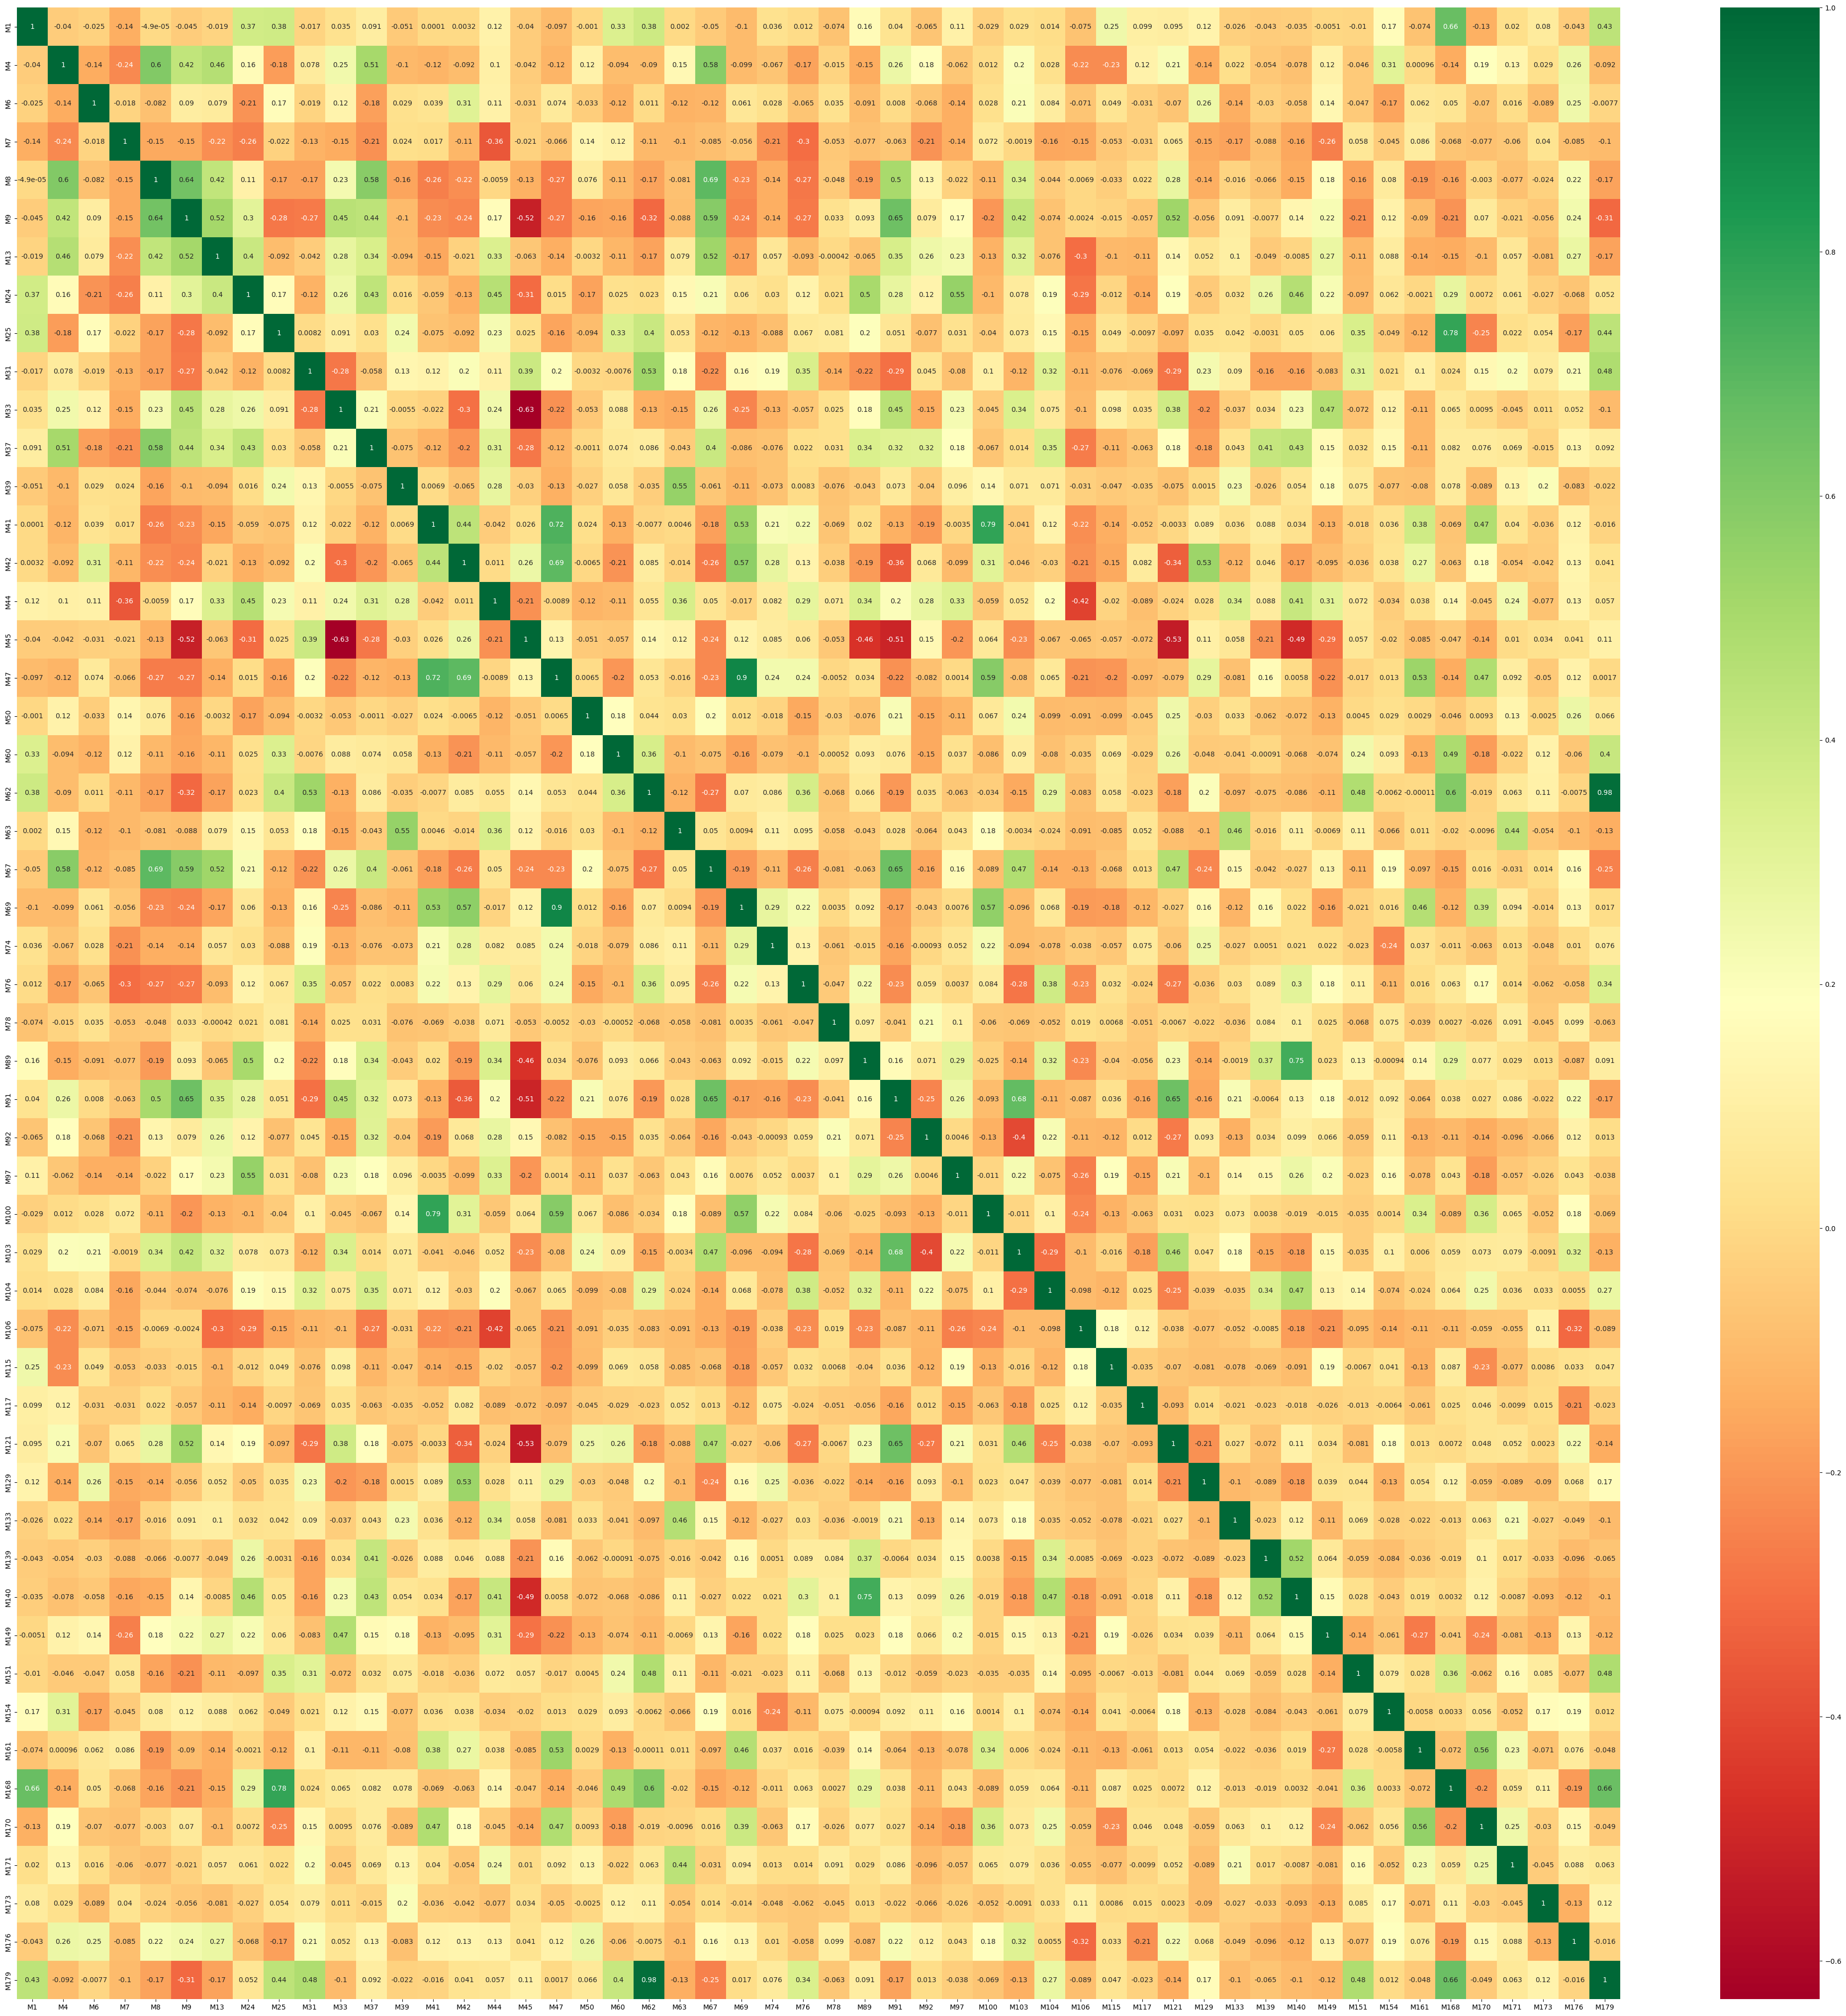

In [146]:
# Otteniamo le correlazioni tra le features
corrmat = X_top.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(k_fs, k_fs))

# Generiamo il grafico delle correlazioni
g=sns.heatmap(X_top[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### 9. Results

I risultati della ricerca sono i seguenti:

In [147]:
# Elenchiamo i risultati migliori

# Numero di fold
kfolds = KFold(n_splits=k_best, shuffle=True, random_state=42)

# Modello PLSRegression
model = PLSRegression(**best_params)

# Applichiamo la K-fold Cross-Validation
y_pred = cross_val_predict(model, X_top, y, cv=kfolds)
threshold = 0.5
y_pred_class = (y_pred[:, 0] > threshold).astype(int)

# Calcoliamo le metriche
accuracy = metrics.accuracy_score(y, y_pred_class)
precision = metrics.precision_score(y, y_pred_class)
recall = metrics.recall_score(y, y_pred_class)
f1 = metrics.f1_score(y, y_pred_class)
roc_auc = metrics.roc_auc_score(y, y_pred_class)

In [148]:
# Stampiamo i risultati
print("------------------------")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

print("------------------------")
print(f'Migliori iperparametri:')
for h in best_params:
    print(f'- {h}: {best_params[h]}')
print("------------------------")
print(f'Features selezionate: {len(best_features)}')
print("------------------------")

------------------------
Accuracy: 0.8160
Precision: 0.8723
Recall: 0.8200
F1-score: 0.8454
ROC AUC: 0.8148
------------------------
Migliori iperparametri:
- max_iter: 500
- n_components: 2
- tol: 1e-06
------------------------
Features selezionate: 52
------------------------


### 10. ROC Curve

In [149]:
x_train, x_test, y_train, y_test = train_test_split(X_knn, y, test_size=0.2, random_state=42)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)

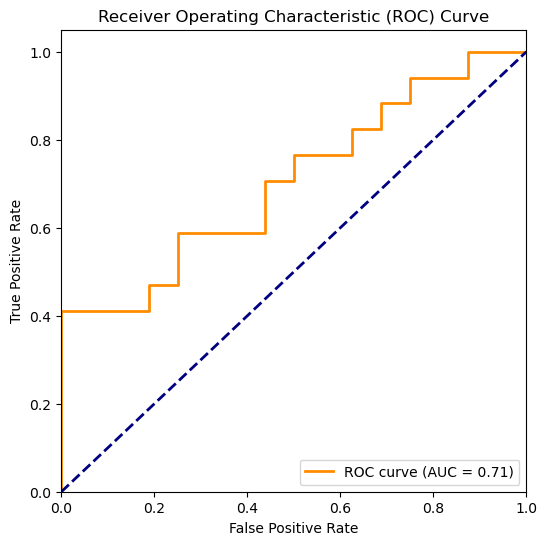

In [150]:
# Calcoliamo la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calcoliamo l'area sotto la curva ROC
roc_auc = auc(fpr, tpr)

# Grafichiamo la curva ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")